In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import torch
import torch.nn as nn
from datasets import load_dataset

from transformers import BertTokenizer, BertForQuestionAnswering, BertConfig

from captum.attr import visualization as viz
from captum.attr import LayerConductance, LayerIntegratedGradients

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# replace <PATd:/spofrte/modeH-TO-SAVED-MODEL> with the real path of the saved model
model_path = 'bert-large-uncased-whole-word-masking-finetuned-squad'

# load model
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
model.to(device)
model.eval()
model.zero_grad()
for name,param in model.named_parameters():
    if name == 'qa_outputs.weight':
        print(type(name), type(param))
        print(name, param)
        print(param.data[0])
        param.data[0] = torch.rand(1024)
        print(param.data[0])

for name,param in model.named_parameters():
    if name == 'qa_outputs.weight':
        print(type(name), type(param))
        print(name, param)
        print(param.data[0])
        param.data[0] = torch.rand(1024)
        print(param.data[0])

# load tokenizer
tokenizer = BertTokenizer.from_pretrained(model_path)


def predict(inputs, token_type_ids=None, position_ids=None, attention_mask=None):
    output = model(inputs, token_type_ids=token_type_ids,
                   position_ids=position_ids, attention_mask=attention_mask, )
    return output.start_logits, output.end_logits


def squad_pos_forward_func(inputs, token_type_ids=None, position_ids=None, attention_mask=None, position=0):
    pred = predict(inputs,
                   token_type_ids=token_type_ids,
                   position_ids=position_ids,
                   attention_mask=attention_mask)
    pred = pred[position]
    return pred.max(1).values

fig = plt.figure()  
fig.set_size_inches(8, 6)

ref_token_id = tokenizer.pad_token_id  # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id  # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id  # A token used for prepending to the concatenated question-text word sequence


def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions


def construct_input_ref_pair(question, text, ref_token_id, sep_token_id, cls_token_id):
    question_ids = tokenizer.encode(question, add_special_tokens=False)
    text_ids = tokenizer.encode(text, add_special_tokens=False)

    # construct input token ids
    input_ids = [cls_token_id] + question_ids + [sep_token_id] + text_ids + [sep_token_id]

    # construct reference token ids
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(question_ids) + [sep_token_id] + \
                    [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(question_ids)


def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)  # * -1
    return token_type_ids, ref_token_type_ids


def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids


def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)


def construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                    token_type_ids=None, ref_token_type_ids=None, \
                                    position_ids=None, ref_position_ids=None):
    input_embeddings = model.bert.embeddings(input_ids, token_type_ids=token_type_ids, position_ids=position_ids)
    ref_input_embeddings = model.bert.embeddings(ref_input_ids, token_type_ids=token_type_ids,
                                                 position_ids=position_ids)

    return input_embeddings, ref_input_embeddings


def predict_qt(question, text):
    input_ids, ref_input_ids, sep_id = construct_input_ref_pair(question, text, ref_token_id, sep_token_id,
                                                                cls_token_id)
    token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
    position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
    attention_mask = construct_attention_mask(input_ids)

    indices = input_ids[0].detach().tolist()
    all_tokens = tokenizer.convert_ids_to_tokens(indices)

    ground_truth = '13'

    start_scores, end_scores = predict(input_ids, \
                                       token_type_ids=token_type_ids, \
                                       position_ids=position_ids, \
                                       attention_mask=attention_mask)

    print('Question: ', question)
    print('Predicted Answer: ', ' '.join(all_tokens[torch.argmax(start_scores): torch.argmax(end_scores) + 1]))
    return input_ids, ref_input_ids, token_type_ids, position_ids, attention_mask, start_scores, end_scores, ground_truth, all_tokens,


def explain(input_ids, ref_input_ids, token_type_ids, position_ids, attention_mask, start_scores, end_scores,
            ground_truth, all_tokens, ):
    lig = LayerIntegratedGradients(squad_pos_forward_func, model.bert.embeddings)

    attributions_start, delta_start = lig.attribute(inputs=input_ids,
                                                    baselines=ref_input_ids,
                                                    additional_forward_args=(
                                                        token_type_ids, position_ids, attention_mask, 0),
                                                    internal_batch_size=4,
                                                    return_convergence_delta=True)
    attributions_end, delta_end = lig.attribute(inputs=input_ids, baselines=ref_input_ids,
                                                additional_forward_args=(
                                                    token_type_ids, position_ids, attention_mask, 1),
                                                internal_batch_size=4,
                                                return_convergence_delta=True)

    attributions_start_sum = summarize_attributions(attributions_start)
    attributions_end_sum = summarize_attributions(attributions_end)
    # storing couple samples in an array for visualization purposes
    start_position_vis = viz.VisualizationDataRecord(
        attributions_start_sum,
        torch.max(torch.softmax(start_scores[0], dim=0)),
        torch.argmax(start_scores),
        torch.argmax(start_scores),
        str(ground_truth),
        attributions_start_sum.sum(),
        all_tokens,
        delta_start)

    end_position_vis = viz.VisualizationDataRecord(
        attributions_end_sum,
        torch.max(torch.softmax(end_scores[0], dim=0)),
        torch.argmax(end_scores),
        torch.argmax(end_scores),
        str(ground_truth),
        attributions_end_sum.sum(),
        all_tokens,
        delta_end)
    #print(all_tokens)
    print('\033[1m', 'Visualizations For Start Position', '\033[0m')
    viz.visualize_text([start_position_vis])

    print('\033[1m', 'Visualizations For End Position', '\033[0m')

    print("attributions_start_sum:   ", len(attributions_start_sum))
    #print("all tokens:    ", len(all_tokens))

    return all_tokens, attributions_start_sum


def get_posneg(all_tokens, attributions_start_sum):
    positive = []
    negative = []
    neutral = []
    for i, j in enumerate(attributions_start_sum):
        if j > 0:
            positive.append(i)
            # print('positive:',j)
        ##print(all_tokens[i])
        elif j < 0:
            negative.append(i)
            # print('negative:',j)
            # print(all_tokens[i])
        elif j == 0:
            neutral.append(i)

    s_pos = ''
    s_neg = ''

    # print(len(attributions_start_sum))
    # print(len(positive))
    # print(len(negative))

    for i in positive:
        s_pos += all_tokens[i] + ' '
    #print("positive :", s_pos)
    for i in negative:
        s_neg += all_tokens[i] + ' '
    #print("negative :", s_neg)
    return positive, negative, neutral


def separate_sentence(all_tokens):
    sentence = {}
    temp = []
    num = 0
    for i in range(len(all_tokens)):
        if all_tokens[i] == "," or all_tokens[i] == ".":
            temp.append(all_tokens[i])
            sentence[num] = temp
            temp = []
            num = num + 1
        elif all_tokens[i] == "[CLS]":
            temp.append(all_tokens[i])
            sentence[num] = temp
            temp = []
            num = num + 1
        elif all_tokens[i] == "[SEP]":
            sentence[num] = temp
            num = num + 1
            temp = [all_tokens[i]]
            sentence[num] = temp
            temp = []
            num = num + 1
        else:
            temp.append(all_tokens[i])
    return sentence
def get_sence_score(sentence, attributions_start_sum):
    weight = 0
    sum_weight = 0
    sentence_value=[]
    delete_sentence = []
    for k,v in sentence.items():
        for i in v:
            sentence_value.append(i)
    scores={}


    for i in range(len(attributions_start_sum)):
        try:
            scores[sentence_value[i]]=attributions_start_sum[i].item()
        except:
            pass


    for i, j in sentence.items():
        sum_weight = 0
        for word in j:
            sum_weight +=  scores[word]
        delete_sentence.append(sum_weight)
        #print(sum_weight)
    return delete_sentence

def get_delete(sentence):
    weight = 0
    sum_weight = 0
    sentence_value = []
    delete_sentence = {}
    for k, v in sentence.items():
        # print(k,':',v)
        for i in v:
            sentence_value.append(i)
    #print(sentence_value)
    scores = {}
    # print(attributions_start_sum[0].item())

    for i in range(len(attributions_start_sum)):
        try:
            scores[sentence_value[i]] = attributions_start_sum[i].item()
        except:
            pass

    for i, j in sentence.items():
        sum_weight = 0
        for word in j:
            weight = 0

            sum_weight += scores[word]
            delete_sentence[i] = sum_weight
    return delete_sentence


def delete_sentence(sentence, li_delete_sentence):
    for i, j in sentence.items():
        if i in li_delete_sentence:
            sentence[i] = []
        else:
            pass
    return sentence


def rebuild_sentence(ori_sentence):
    rebuild_str = ""
    for i, j in ori_sentence.items():
        for word in j:
            rebuild_str += word
            rebuild_str += " "
    return rebuild_str


def pred_explain(question, text):
    input_ids, ref_input_ids, token_type_ids, position_ids, attention_mask, start_scores, end_scores, ground_truth, all_tokens, = predict_qt(
        text, question)

    all_tokens, attributions_start_sum = explain(input_ids, ref_input_ids, token_type_ids, position_ids, attention_mask,
                                                 start_scores, end_scores, ground_truth, all_tokens, )

    end_score = float(torch.max(torch.softmax(end_scores[0], dim=0)))
    start_score = float(torch.max(torch.softmax(start_scores[0], dim=0)))
    return all_tokens, attributions_start_sum, end_score, start_score, [torch.argmax(start_scores), torch.argmax(end_scores)+1], start_scores, end_scores
def max_min(x, y, z):
    max = min = x
    i = 1
    if y > max:
        max = y
        i = 2
    else:
        min = y
    if z > max:
        max = z
        i =3
    else:
        min = z
    return (i)
def cycle_prediction(cycle_num, question, text):
    all_tokens, attributions_start_sum, start_acc, end_acc,  an_index, start_scores, end_scores = pred_explain(text, question)
    first_answer = ' '.join(all_tokens[torch.argmax(start_scores): torch.argmax(end_scores) + 1])
    first_answer = re.sub(r' ##', '', first_answer)
    print("my answer is ", first_answer)
    print(start_acc, end_acc)
    second_answer = ''
    sentence = separate_sentence(all_tokens)
    a = 0
    pos_contri = 0
    neg_contri = 0
    average_neg = []
    average_pos = []
    for i, j in enumerate(attributions_start_sum):
        if j <0 : 
            neg_contri+= j
        elif j >0:
            pos_contri += j
    print("positive contribution:", pos_contri)
    average_pos.append(pos_contri)
    print("negative contribution:", neg_contri)
    average_neg.append(neg_contri)

    acc_s = []
    acc_e = []
    sun = []
    ans = []
    ans.append(first_answer)
    #print(start_acc, end_acc)
    acc_s.append(start_acc)
    acc_e.append(end_acc)

    for loop in range(cycle_num):
        sentence = separate_sentence(all_tokens)
        sentence_score  = get_sence_score(sentence, attributions_start_sum)
        min_sensocer = 999
        min_index = 999
        for i in range(len(sentence_score)):
            if sentence_score[i] < min_sensocer and sentence_score[i] != 0:
                min_sensocer = sentence_score[i]
                min_index = i
        #print("should delete", min_index, min_sensocer)
        sentence[min_index] = ''
        sentence[1] = ''
        retext = ""
        for i, j in sentence.items():
            for words in j:
                retext = retext + words + " "
        li_sep = []
        for m in re.finditer(r"SEP", retext):
            li_sep.append(m.start())
            li_sep.append(m.end())
        retext = retext[li_sep[1]+1: li_sep[2] -1]
        retext = re.sub(r' ##', '', retext)



        all_tokens, attributions_start_sum, start_acc, end_acc,  an_index, start_scores, end_scores= pred_explain(retext, question)
        reanswer = ' '.join(all_tokens[torch.argmax(start_scores): torch.argmax(end_scores) + 1])
        #print(start_acc, end_acc)
        second_answer = ' '.join(all_tokens[torch.argmax(start_scores): torch.argmax(end_scores) + 1])
        second_answer = re.sub(r' ##', '', second_answer)
        #print("my answer is ", second_answer)
        ans.append(second_answer)
        #print(start_acc, end_acc)
        acc_s.append(start_acc)
        acc_e.append(end_acc)
        pos_contri = 0
        neg_contri = 0
        for i, j in enumerate(attributions_start_sum):
            if j <0:
                neg_contri+= j
            elif j >0:
                pos_contri += j
        print("positive contribution:", pos_contri)
        average_pos.append(pos_contri)
        print("negative contribution:", neg_contri)
        average_neg.append(neg_contri)


        #print(acc_s, acc_e)
        #print(acc_s, acc_e)
    plt.plot(range(len(acc_s)), acc_s, label = 'start score')
    plt.plot(range(len(acc_s)), acc_e, label = 'end score')
    sun = []
    for i in range(len(acc_s)):
        sun.append((acc_s[i] + acc_e[i])/2)
    print(sun)
    plt.plot(range(len(acc_s)), sun, label = 'average')
    plt.xlabel('Number of predictions')
    plt.ylabel('Possibility')    
    plt.legend()
    plt.show()
        
    """"获取最好的曲线并输出"""
    max_start = 0
    max_end = 0
    max_ave = 0
    for i in acc_s:
        if i > max_start:
            max_start = i
    for j in acc_e:
        if j > max_end:
            max_end = i

    for x in sun:
        if x > max_ave:
            max_ave = x

    print(max_start ,max_end ,max_ave )


    max_list = max_min(max_start, max_end, max_ave)
    if max_list == 1:
        plt.plot(range(len(acc_s)), acc_s, label = 'Possibility')
        print(acc_s)
    if max_list == 2:
        plt.plot(range(len(acc_e)), acc_e, label = 'Possibility')
        print(acc_e)
    if max_list == 3:
        plt.plot(range(len(sun)), sun, label = 'Possibility')
        print(sun)

    plt.xlabel('Number of predictions')
    plt.ylabel('Possibility')
    plt.legend()
    plt.show()
    """贡献的数值分别是多少"""
    plt.plot(range(len(average_pos)), average_pos, label = 'pos score')
    plt.plot(range(len(average_neg)), average_neg, label = 'neg score')
    plt.xlabel('Number of predictions')
    plt.ylabel('average contribution of pos/neg')    
    plt.legend()
    plt.show()
    for i in range(len(ans)):
        print(ans[i], "pos/neg : ", -(average_pos[i]/average_neg[i]))
    average_contribution = 0

<class 'str'> <class 'torch.nn.parameter.Parameter'>
qa_outputs.weight Parameter containing:
tensor([[ 0.0234, -0.0060,  0.0238,  ..., -0.0315, -0.0137,  0.0296],
        [ 0.0481,  0.0265,  0.0083,  ...,  0.0021, -0.0065,  0.0082]],
       device='cuda:0', requires_grad=True)
tensor([ 0.0234, -0.0060,  0.0238,  ..., -0.0315, -0.0137,  0.0296],
       device='cuda:0')
tensor([0.2299, 0.2699, 0.3726,  ..., 0.9841, 0.2509, 0.4795], device='cuda:0')
<class 'str'> <class 'torch.nn.parameter.Parameter'>
qa_outputs.weight Parameter containing:
tensor([[ 0.2299,  0.2699,  0.3726,  ...,  0.9841,  0.2509,  0.4795],
        [ 0.0481,  0.0265,  0.0083,  ...,  0.0021, -0.0065,  0.0082]],
       device='cuda:0', requires_grad=True)
tensor([0.2299, 0.2699, 0.3726,  ..., 0.9841, 0.2509, 0.4795], device='cuda:0')
tensor([0.4377, 0.4160, 0.3894,  ..., 0.2091, 0.1784, 0.3731], device='cuda:0')


<Figure size 576x432 with 0 Axes>

In [2]:
text = "A self-described 'modern-day feminist', Beyoncé creates songs that are often characterized by themes of love, relationships, and monogamy, as well as female sexuality and empowerment. On stage, her dynamic, highly choreographed performances have led to critics hailing her as one of the best entertainers in contemporary popular music. Throughout a career spanning 19 years, she has sold over 118 million records as a solo artist, and a further 60 million with Destiny's Child, making her one of the best-selling music artists of all time. She has won 20 Grammy Awards and is the most nominated woman in the award's history. The Recording Industry Association of America recognized her as the Top Certified Artist in America during the 2000s decade. In 2009, Billboard named her the Top Radio Songs Artist of the Decade, the Top Female Artist of the 2000s and their Artist of the Millennium in 2011. Time listed her among the 100 most influential people in the world in 2013 and 2014. Forbes magazine also listed her as the most powerful female musician of 2015."
question = "What magazine named Beyoncé as the most powerful female musician for 2015?"

all_tokens, attributions_start_sum, start_acc, end_acc,  an_index, start_scores, end_scores = pred_explain(text, question)

Question:  What magazine named Beyoncé as the most powerful female musician for 2015?
Predicted Answer:  of all time . she has won 20 grammy awards and is the most nominated woman in the award ' s history . the recording industry association of america recognized her as the top certified artist in america during the 2000s decade . in 2009 , billboard named her the top radio songs artist of the decade , the top female artist of the 2000s and their artist of the millennium in 2011 . time listed her among the 100 most influential people in the world in 2013 and 2014 . forbes
 Visualizations For Start Position 


 Visualizations For End Position 
attributions_start_sum:    227


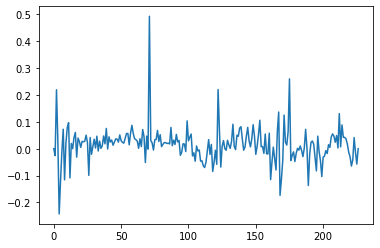

In [3]:
attr_nomal = []
for i, j in enumerate(attributions_start_sum):
    attr_nomal.append(j)
plt.plot(range(len(attr_nomal)), attr_nomal)
plt.show()